# Concat

In [41]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [42]:
train_df_down = pd.read_csv('/Users/luzhang/Desktop/indicator/y_label_down.csv', index_col=0)
train_df_up = pd.read_csv('/Users/luzhang/Desktop/indicator/y_label_up.csv', index_col=0)


train_df_down['CMO_file'] = train_df_down.index.map(lambda id: f'/Users/luzhang/Desktop/balanced_features/CMO/downspectrum/Downspectrum{id}.png')
train_df_up['CMO_file'] = train_df_up.index.map(lambda id: f'/Users/luzhang/Desktop/balanced_features/CMO/upspectrum/Upspectrum{id}.png')

train_df_down['aroon_file'] = train_df_down.index.map(lambda id: f'/Users/luzhang/Desktop/balanced_features/aroon/downspectrum/Downspectrum{id}.png')
train_df_up['aroon_file'] = train_df_up.index.map(lambda id: f'/Users/luzhang/Desktop/balanced_features/aroon/upspectrum/Upspectrum{id}.png')

frames=[train_df_down, train_df_up]
train_df=pd.concat(frames)

In [43]:
def read_spectograms(file_paths, img_rows, img_cols, as_gray, channels):
  """
  Reads the spectogram files from disk and normalizes the pixel values
    @params:
      file_paths - Array of file paths to read from
      img_rows - The image height.
      img_cols - The image width.
      as_grey - Read the image as Greyscale or RGB.
      channels - Number of channels.
    @returns:
      The created and compiled model (Model)        
  """
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path, as_gray = as_gray))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

In [58]:
as_gray = True
in_channel = 3

if as_gray:
  in_channel = 1

#in_channel = 1

img_rows, img_cols = 480, 480
num_classes = 2 # number of class
batch_size = 32
epochs = 25
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

In [45]:
x_train_CMO = read_spectograms(train_df.CMO_file.values, img_rows, img_cols, as_gray, in_channel)

In [46]:
x_train_aroon = read_spectograms(train_df.aroon_file.values, img_rows, img_cols, as_gray, in_channel)

In [36]:
labels = train_df.Y.values
# convert class vectors to binary class matrices One Hot Encoding
labels = keras.utils.to_categorical(labels, num_classes)

In [48]:
Y = [ 'down','up']

# pick a random index from the list
rn_Y = np.random.choice(train_df.Y.values)
rn_label = train_df.Y.values[rn_Y]
rn_CMO = x_train_CMO[rn_Y]
rn_aroon = x_train_aroon[rn_Y]
#print(rn_label)
#print(rn_CMO)
#print(rn_aroon)

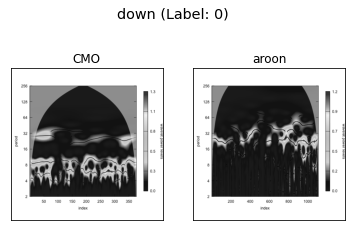

In [50]:
plt.figure()
plt.axis('off')

plt.suptitle(f"{Y[rn_label]} (Label: {rn_label})", fontsize="x-large")

plt.subplot(121)
curr_img = None
if as_gray:
  curr_img = np.reshape(rn_CMO, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_CMO, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("CMO")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
if as_gray:
  curr_img = np.reshape(rn_aroon, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_aroon, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("aroon")
plt.xticks([])
plt.yticks([])
plt.show()

In [51]:
# stack so we can split on the same pair of images
x_train_comp = np.stack((x_train_CMO, x_train_aroon), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=1)

# take them apart
x_train_CMO = x_train[:,:,:,:,0]
x_test_CMO = x_test[:,:,:,:,0]

x_train_aroon = x_train[:,:,:,:,1]
x_test_aroon = x_test[:,:,:,:,1]

In [52]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.4)(model)
    
  return model

In [53]:
current_input = Input(shape=input_shape)
current_model = create_convolution_layers(current_input)

voltage_input = Input(shape=input_shape)
voltage_model = create_convolution_layers(voltage_input)

conv = concatenate([current_model, voltage_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='sigmoid')(dense)

model = Model(inputs=[current_input, voltage_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 480, 480, 1) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 480, 480, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 480, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 480, 480, 32) 320         input_8[0][0]                    
______________________________________________________________________________________________

In [59]:
best_weights_file="weights.best.hdf5"
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#lr_reducer = ReduceLROnPlateau(verbose=1)

callbacks = [checkpoint]

model.fit([x_train_CMO, x_train_aroon], y_train,
          batch_size = batch_size,
          epochs=epochs,
          callbacks=callbacks,
          verbose=1,
          validation_data=([x_test_CMO, x_test_aroon], y_test),
          shuffle=True)

Epoch 1/25
68/68 [==============================] - 478s 7s/step - loss: 1.4099 - accuracy: 0.5142 - val_loss: 21.8917 - val_accuracy: 0.5147
Epoch 2/25
68/68 [==============================] - 486s 7s/step - loss: 0.8205 - accuracy: 0.5012 - val_loss: 6.1629 - val_accuracy: 0.5147
Epoch 3/25
68/68 [==============================] - 482s 7s/step - loss: 0.7457 - accuracy: 0.4918 - val_loss: 7.2916 - val_accuracy: 0.5147
Epoch 4/25
 1/68 [..............................] - ETA: 7:37 - loss: 0.6327 - accuracy: 0.5312

KeyboardInterrupt: 